# TP 3: Classification

## Quick Recap: Classification

**Classification** = predicting a **category/label** from data.

Examples:
- Identify malicious traffic vs normal traffic *(binary)*
- Classify network applications (Web, Video, Gaming, VoIP) *(multiclass)*


### How Classification Works
- Classification is **supervised learning**: the model trains on data with known labels.
- The model learns patterns and predicts a **class** for new unseen data, often by estimating **probabilities** first.
- A **decision boundary** separates classes in the feature space (e.g., normal vs malicious traffic).

## 📝 Exercise 1: K-Nearest Neighbors (KNN)

### Preparation: Generating "synthetic" data

- We simulate a simple bank-customer dataset with two groups.  
- Each class has different average balance and similar income and we sample points from Gaussian distributions to mimic real financial variation.  
- We also create a binary `student` feature and a `default` label (0 or 1).  
- This dataset will be used to practice KNN classification.


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(100)

# Means
mu_class0 = [700, 3000]
mu_class1 = [1350, 3000]

# Covariance matrices
cov_class0 = [[70000, 0], [0, 900000]]
cov_class1 = [[70000, 0], [0, 900000]]

n = 300  # samples per class

# Generate 2D Gaussian data: (balance, income)
balance0, income0 = np.random.multivariate_normal(mu_class0, cov_class0, n).T
balance1, income1 = np.random.multivariate_normal(mu_class1, cov_class1, n).T

# Ensure no negative data values
balance0 = np.maximum(balance0, 0)
income0  = np.maximum(income0, 0)
balance1 = np.maximum(balance1, 0)
income1  = np.maximum(income1, 0)

# Combine classes
balance = np.concatenate([balance0, balance1])
income  = np.concatenate([income0, income1])

# Labels: 0 = class0, 1 = class1
labels = np.array([0]*n + [1]*n)

# Student indicator
max_balance = balance.max()
student = (np.random.rand(len(balance)) < (balance / max_balance) / 2).astype(int)

# Build dataframe
df = pd.DataFrame({
    "balance": balance,
    "income": income,
    "student": student,
    "default": labels
})

df.head()

balance       income  student  default
0  790.664713  1340.026720        1        0
1  633.211703  4093.865808        1        0
2  836.049517  3930.962641        0        0
3  416.893146  3209.829458        0        0
4  767.467041  2820.228470        0        0

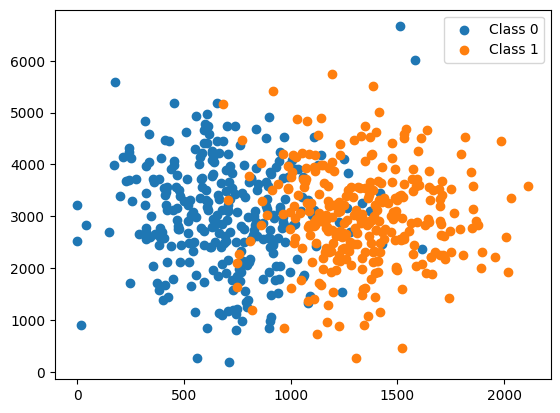

In [54]:
# Plot the synthetic data
plt.scatter(df.balance[df.default==0], df.income[df.default==0], label="Class 0")
plt.scatter(df.balance[df.default==1], df.income[df.default==1], label="Class 1")

plt.legend()
plt.show()

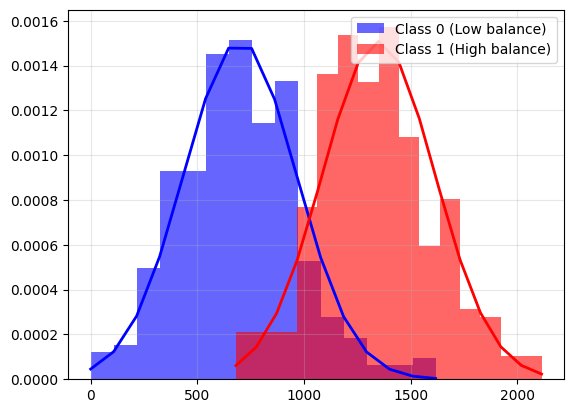

In [55]:
# Plot histograms for balance distributions of each class
count0, bins0, _ = plt.hist(balance0, bins=15, density=True, alpha=0.6, color='blue', label='Class 0 (Low balance)')
count1, bins1, _ = plt.hist(balance1, bins=15, density=True, alpha=0.6, color='red', label='Class 1 (High balance)')

plt.plot(
    bins0,
    1 / np.sqrt(2 * np.pi * cov_class0[0][0]) * np.exp(- (bins0 - mu_class0[0])**2 / (2 * cov_class0[0][0])),
    linewidth=2,
    color='blue'
)
plt.plot(
    bins1,
    1 / np.sqrt(2 * np.pi * cov_class1[0][0]) * np.exp(- (bins1 - mu_class1[0])**2 / (2 * cov_class1[0][0])),
    linewidth=2,
    color='red'
)

plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Part A — Visualizing the KNN Decision Boundary

Using the dataset you created:

1. Train a **K-Nearest Neighbors (KNN)** classifier using the entire dataset (no train/test split).  
2. Use only the features `balance` and `income`.
3. Try the following values of \( K = 1, 3, 10, 40 \).

For each value of \( K \):
- Fit the KNN model.
- Plot the decision boundary in 2D.
- Overlay the data points for both classes on the same plot.

In [56]:
from sklearn.neighbors import KNeighborsClassifier

# Values of k to test
k_values = [1, 3, 10, 40]

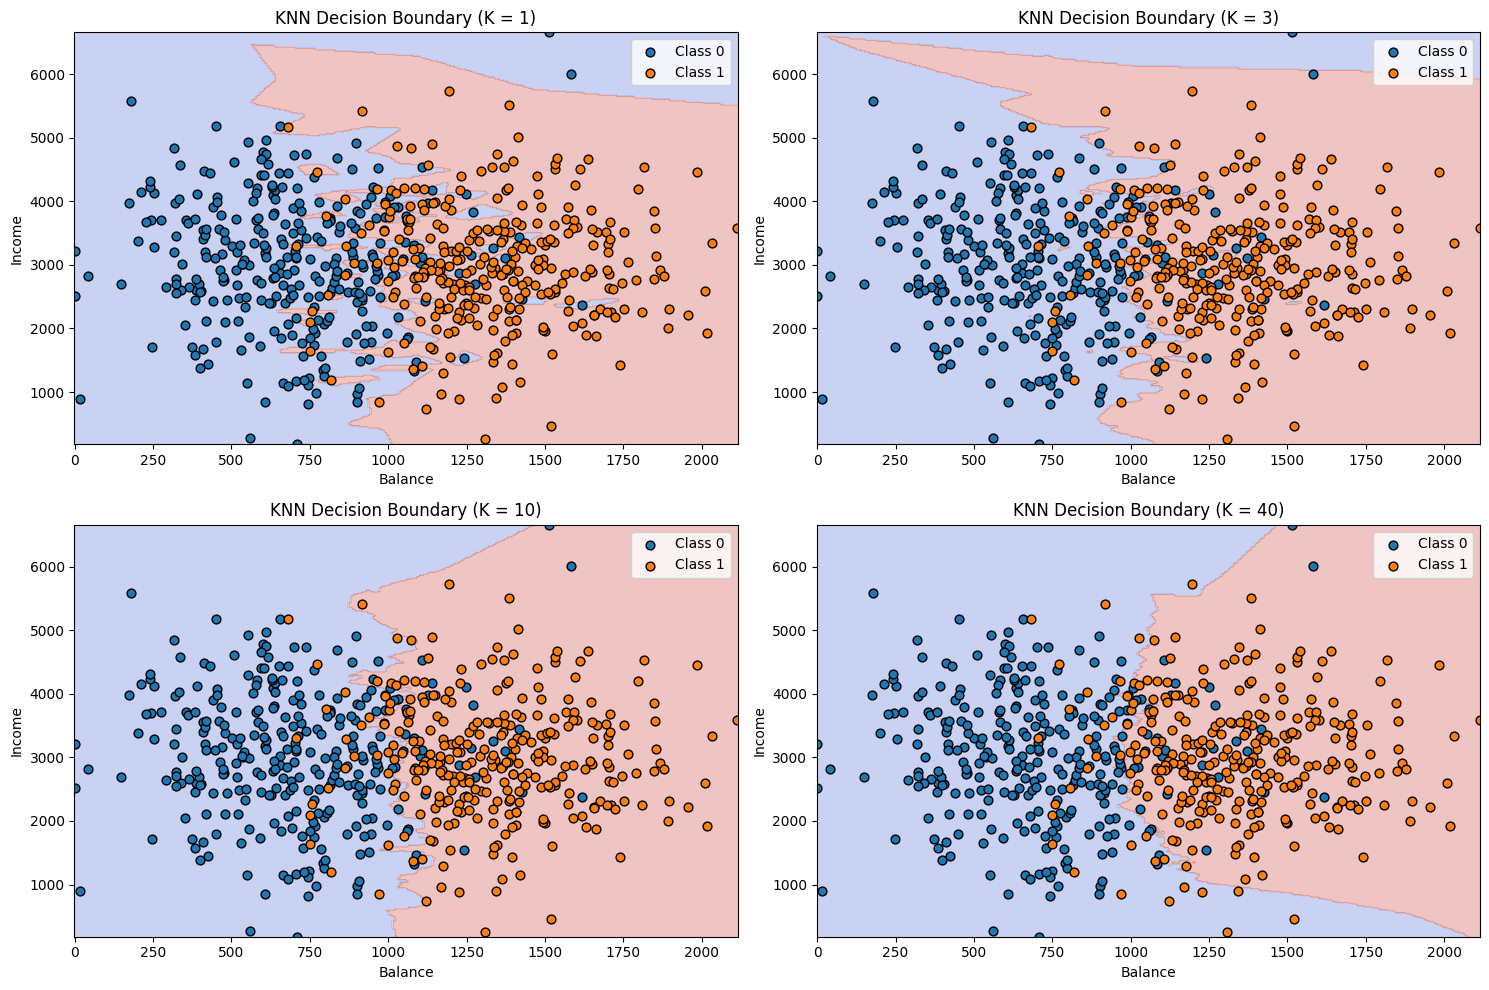

In [57]:
## TODO:

X = df[['balance', 'income']].values
y = df['default'].values


x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

plt.figure(figsize=(15, 10))

for i, k in enumerate(k_values, 1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(2, 2, i)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[y==0, 0], X[y==0, 1], label='Class 0', edgecolor='k', s=40)
    plt.scatter(X[y==1, 0], X[y==1, 1], label='Class 1', edgecolor='k', s=40)
    plt.title(f'KNN Decision Boundary (K = {k})')
    plt.xlabel('Balance')
    plt.ylabel('Income')
    plt.legend()

plt.tight_layout()
plt.show()


### Part B — Choosing the Best K using Cross-Validation

1. Use only the features **`balance`** and **`income`**.
2. For \( K = 1, 2, \dots, 100 \):
   - Perform cross-validation using `sklearn.model_selection.cross_validate`.
   - Use the following scoring metrics:
     - `accuracy`
     - `roc_auc`
     - `neg_mean_absolute_error`
   - Record both **Train** and **Test** scores for each metric.

3. For each metric, compute the **mean Train** and **mean Test** scores across folds.

4. Plot **three figures**:
   - Accuracy vs \( K \)
   - ROC-AUC vs \( K \)
   - MAE vs \( K \)  *(remember: MAE = − `neg_mean_absolute_error`)*

   Each figure should contain **two curves** — one for **Train**, one for **Test** — with the **x-axis** in **logarithmic** scale and the **y-axis** in **linear** scale.


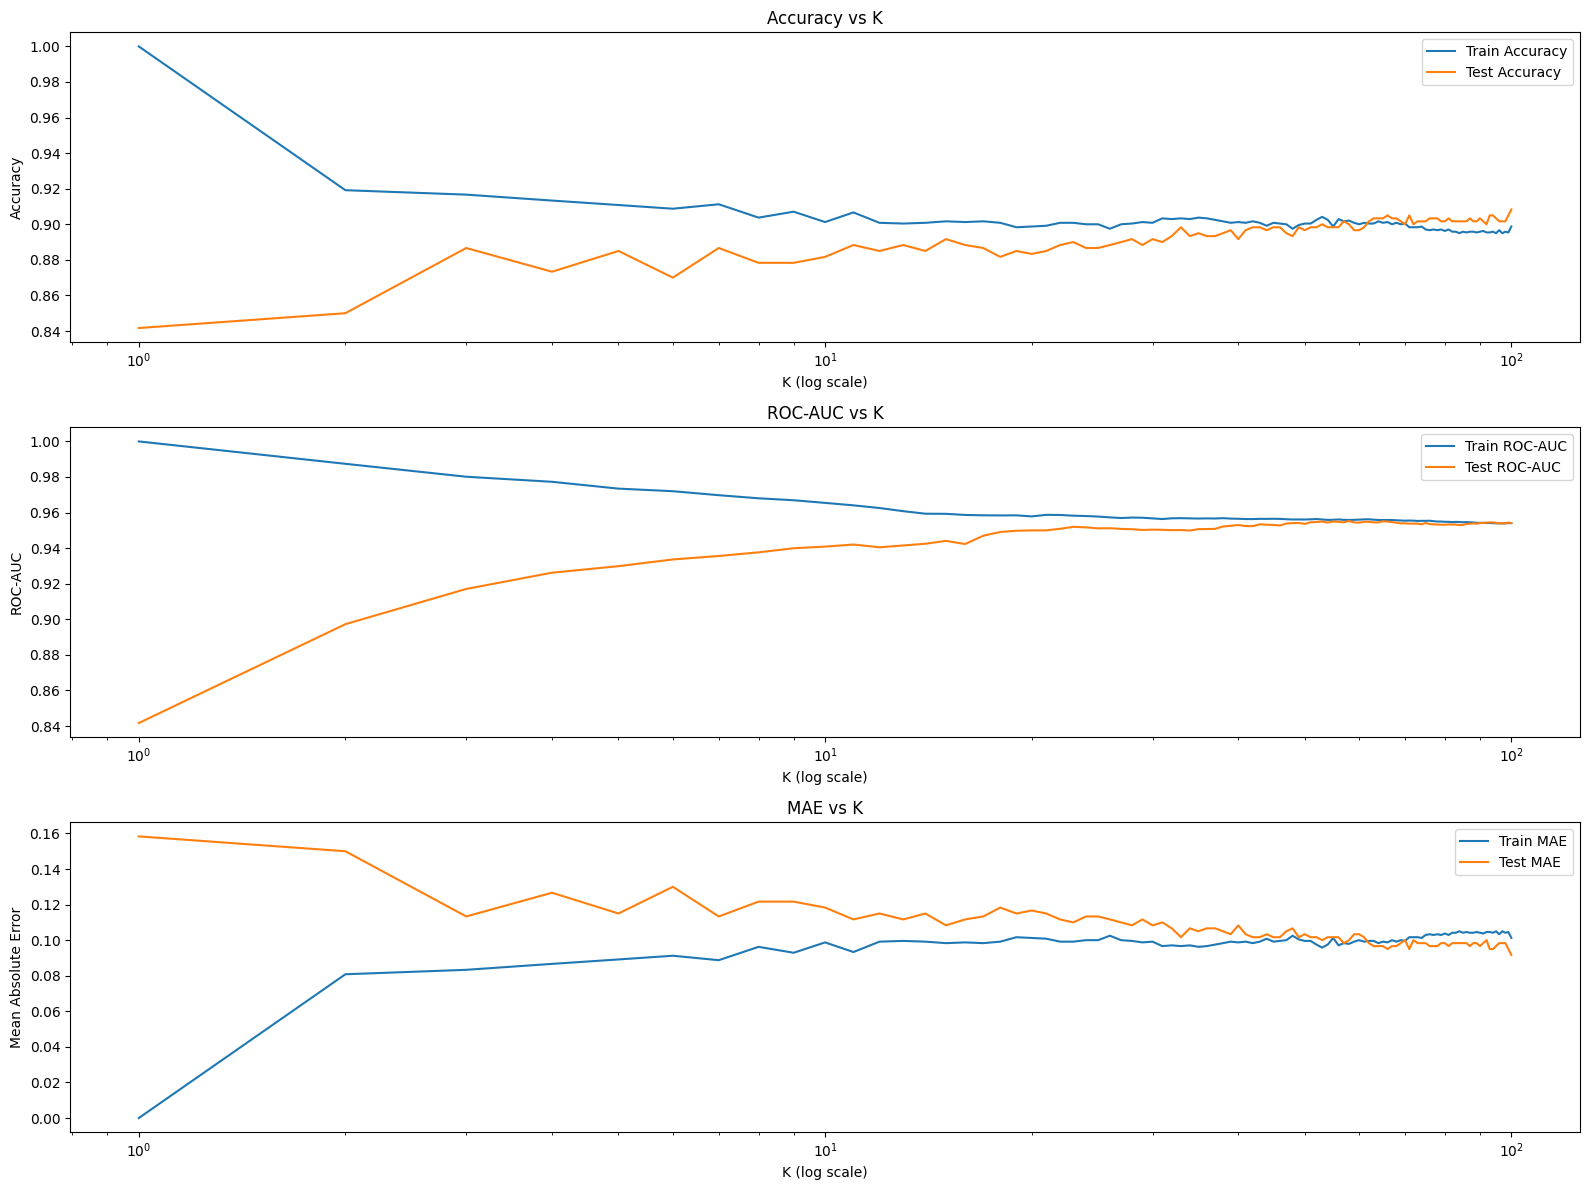

In [58]:
## TODO:

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
k_values = range(1, 101)
scoring = ['accuracy', 'roc_auc', 'neg_mean_absolute_error']

results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    cv_results = cross_validate(
        knn,
        X_scaled,
        y,
        cv=5,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    mean_train_acc = np.mean(cv_results['train_accuracy'])
    mean_test_acc = np.mean(cv_results['test_accuracy'])
    
    mean_train_auc = np.mean(cv_results['train_roc_auc'])
    mean_test_auc = np.mean(cv_results['test_roc_auc'])
    
    mean_train_mae = -np.mean(cv_results['train_neg_mean_absolute_error']) 
    mean_test_mae = -np.mean(cv_results['test_neg_mean_absolute_error'])
    
    results.append({
        'K': k,
        'train_accuracy': mean_train_acc,
        'test_accuracy': mean_test_acc,
        'train_roc_auc': mean_train_auc,
        'test_roc_auc': mean_test_auc,
        'train_mae': mean_train_mae,
        'test_mae': mean_test_mae
    })


results_df = pd.DataFrame(results)

plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.plot(results_df['K'], results_df['train_accuracy'], label='Train Accuracy')
plt.plot(results_df['K'], results_df['test_accuracy'], label='Test Accuracy')
plt.xscale('log')
plt.xlabel('K (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(results_df['K'], results_df['train_roc_auc'], label='Train ROC-AUC')
plt.plot(results_df['K'], results_df['test_roc_auc'], label='Test ROC-AUC')
plt.xscale('log')
plt.xlabel('K (log scale)')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC vs K')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(results_df['K'], results_df['train_mae'], label='Train MAE')
plt.plot(results_df['K'], results_df['test_mae'], label='Test MAE')
plt.xscale('log')
plt.xlabel('K (log scale)')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs K')
plt.legend()

plt.tight_layout()
plt.show()


#### Questions:

- Which value of \( K \) gives the best overall performance?
- Do Train and Test curves agree on the optimal \( K \)?
- How does the Test Classification Error change as \( K \) increases?
- What do these results tell you about **overfitting** and **underfitting** in KNN?

In [59]:
# Find K with the highest test accuracy
best_k = results_df.loc[results_df['test_accuracy'].idxmax(), 'K']

# Get the corresponding test accuracy
best_test_acc = results_df.loc[results_df['test_accuracy'].idxmax(), 'test_accuracy']

# Compute test error (1 - accuracy)
knn_test_error = 1 - best_test_acc

print("Optimal K:", best_k)
print("Optimal KNN test accuracy:", best_test_acc)
print("Optimal KNN test error:", knn_test_error)


Optimal K: 100
Optimal KNN test accuracy: 0.9083333333333334
Optimal KNN test error: 0.09166666666666656


#### Answer:

In [60]:
# TODO:


# 1) According to the computation, the optimal K is 100, giving the highest test accuracy (~0.9083).
# 2) However, from the plotted curves, the performance plateaus between K ≈ 20 and 30, 
#    indicating that the model already achieves near-optimal performance in this range.
# 3) The test classification error decreases rapidly as K increases from 1 to about 20,
#    reflecting improved generalization as overfitting is reduced.
# 4) For small K, the model overfits — it memorizes the training data and performs poorly on unseen samples.
#    For moderate K (around 20–30), it achieves a good balance between bias and variance.
#    For very large K (such as 100), the model begins to underfit slightly, becoming too simple to capture finer patterns.



## 📝 Exercise 2: Binary Classification with Logistic Regression

1. **Split the dataset:**
   - Divide the data into **Train (70%)** and **Test (30%)** sets.

2. **Train the model:**
   - Fit a **Logistic Regression** classifier on the training data.
   - Predict the label for the first test sample using:

     ```python
     logistic.predict(X_test[0])
     logistic.predict_proba([X_test[0]])
     ```
   - Observe and describe what these two functions return (class label vs. probability).

3. **Compute model accuracy:**
   - Use ```logreg.score(X_test, y_test)``` to calculate the **mean prediction accuracy**.

In [61]:
## TODO:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df[['balance', 'income']]
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

label_pred = logreg.predict([X_test.iloc[0]])          
proba_pred = logreg.predict_proba([X_test.iloc[0]])  

print("Predicted label:", label_pred)
print("Predicted probabilities:", proba_pred)


Predicted label: [1]
Predicted probabilities: [[0.00192587 0.99807413]]


c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


logreg.predict() returns the predicted class label (0 or 1).

logreg.predict_proba() returns the probability of each class as an array.

In [62]:

accuracy = logreg.score(X_test, y_test)
print(f"Model Accuracy on Test Set: {accuracy:.3f}")


Model Accuracy on Test Set: 0.867


4. **Repeat for multiple splits:**

   - Split the dataset in several different random ways.
   - For each split:
     - Fit the logistic regression model.
     - Calculate the **test error rate**.
   - Compute the **average test error** over all splits.
   - Compare this average error rate to the optimal KNN test error found in Exercise 1.
   - Discuss what you observe.

In [63]:
## TODO:

from sklearn.metrics import accuracy_score

n_splits = 50
test_errors = []

for i in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
    
    error_rate = 1 - accuracy_score(y_test, y_pred)
    test_errors.append(error_rate)

avg_test_error = np.mean(test_errors)
print("Average logistic regression test error over multiple splits:", avg_test_error)

knn_test_error = 0.09166666666666656 
print("Optimal KNN test error:", knn_test_error)

if avg_test_error < knn_test_error:
    print("Logistic Regression performs better on average than KNN.")
else:
    print("KNN performs better on average than Logistic Regression.")

Average logistic regression test error over multiple splits: 0.10288888888888888
Optimal KNN test error: 0.09166666666666656
KNN performs better on average than Logistic Regression.


5. **Analyze model performance:**

    - For the last train–test split, compute the **confusion matrix**.
    - Calculate and report the following performance metrics:
      - Accuracy (ACC)
      - True Positive Rate (TPR / Recall)
      - False Positive Rate (FPR)
      - Precision (PPV) 

In [64]:
## TODO:

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print("\nLabels: [[TN, FP], [FN, TP]]\n")


accuracy = accuracy_score(y_test, y_pred)
tpr = recall_score(y_test, y_pred) 
fpr = fp / (fp + tn)
precision = precision_score(y_test, y_pred)


print(f"Accuracy (ACC): {accuracy:.4f}")
print(f"True Positive Rate (TPR / Recall): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"Precision (PPV): {precision:.4f}")



Confusion Matrix:
[[75 13]
 [ 4 88]]

Labels: [[TN, FP], [FN, TP]]

Accuracy (ACC): 0.9056
True Positive Rate (TPR / Recall): 0.9565
False Positive Rate (FPR): 0.1477
Precision (PPV): 0.8713


6. **Repeat using Cross-Validation:**

   - Repeat the whole processes using **cross validation**
   - Use `sklearn.model_selection.cross_validate` to perform cross-validation on the logistic model.
   - Compare the results with the previous test errors.

In [65]:
## TODO:

X = df[['balance', 'income']]
y = df['default']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logreg = LogisticRegression(max_iter=1000)

scoring = ['accuracy', 'roc_auc', 'neg_mean_absolute_error']
cv_results = cross_validate(
    logreg,
    X_scaled,
    y,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Accuracy
mean_test_acc = np.mean(cv_results['test_accuracy'])
mean_train_acc = np.mean(cv_results['train_accuracy'])

# ROC-AUC
mean_test_auc = np.mean(cv_results['test_roc_auc'])
mean_train_auc = np.mean(cv_results['train_roc_auc'])

# Mean Absolute Error
mean_test_mae = -np.mean(cv_results['test_neg_mean_absolute_error']) 
mean_train_mae = -np.mean(cv_results['train_neg_mean_absolute_error'])

print("Cross-Validation Results (Logistic Regression):")
print(f"Mean Train Accuracy: {mean_train_acc:.4f}")
print(f"Mean Test Accuracy:  {mean_test_acc:.4f}")
print(f"Mean Train ROC-AUC:  {mean_train_auc:.4f}")
print(f"Mean Test ROC-AUC:   {mean_test_auc:.4f}")
print(f"Mean Train MAE:      {mean_train_mae:.4f}")
print(f"Mean Test MAE:       {mean_test_mae:.4f}")


print(f"Optimal KNN test error (K=100): {knn_test_error:.4f}")
print(f"Logistic Regression CV test error: {1 - mean_test_acc:.4f}")

if (1 - mean_test_acc) < knn_test_error:
    print("Logistic Regression performs better than KNN on average.")
else:
    print("KNN performs better than Logistic Regression on average.")




Cross-Validation Results (Logistic Regression):
Mean Train Accuracy: 0.8988
Mean Test Accuracy:  0.8950
Mean Train ROC-AUC:  0.9540
Mean Test ROC-AUC:   0.9548
Mean Train MAE:      0.1012
Mean Test MAE:       0.1050
Optimal KNN test error (K=100): 0.0917
Logistic Regression CV test error: 0.1050
KNN performs better than Logistic Regression on average.


## 📝 Exercise 3: Multinomial (Softmax) Logistic Regression

1) **Load the data (same source as the notebook):**

   - Quickly inspect with `df.shape`, `df.head()`.

In [66]:
import pandas as pd

# Replace with the correct filename if needed
filename = "network_dataset.csv"
df = pd.read_csv(filename)

display(df.head())


RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
0           6.1           29               57       2372          79344   
1           5.8            7               39        625          52973   
2           7.3           16               23       1056          34178   
3          39.2           14               29       3377          36821   
4           4.6            9               77        900         104389   

           IPSrc0           IPDst0 Protocol0  PacketsSent0  PacketsReceived0  \
0   192.168.1.190    173.194.55.23      QUIC            29                57   
1   192.168.1.190   74.125.155.199      QUIC             4                36   
2   192.168.1.190   74.125.155.201       TCP            16                23   
3   192.168.1.190   172.217.135.40         0             0                 0   
4   192.168.1.190  173.194.184.103      QUIC             9                77   

   ...  BufferValid  KBytesReceived  label label_num KBytesReceived_log  \
0  ...         True          79.344  q480p       480           4.373793   
1  ...         True          52.973  q360p       360           3.969782   
2  ...         True          34.178  q720p       720           3.531582   
3  ...         True          36.821  q144p       144           3.606068   
4  ...         True         104.389  q360p       360           4.648124   

   PacketsSent_log  PacketsReceived_log  BytesSent_log  BytesReceived_log  \
0         3.401197             4.060443       7.771910          11.281561   
1         2.079442             3.688879       6.439350          10.877557   
2         2.833213             3.178054       6.963190          10.439367   
3         2.708050             3.401197       8.125039          10.513851   
4         2.302585             4.356709       6.803505          11.555889   

  BufferProgress_log  
0           0.005164  
1           0.004833  
2           0.005473  
3           0.009268  
4           0.006599  

[5 rows x 207 columns]

2) **Create multiclass target variables:**

    - Create a **multiclass target variable** called `res` to use in Multinomial Logistic Regression:

    - The dataset currently contains a numeric label column called `label_num`, which represents the **resolution** of network traffic (e.g., video streaming quality). Transform this numeric value into three categories:

        - **0 → Low resolution** (below 240)  
        - **1 → Mid resolution** (between 240 and 480)  
        - **2 → High resolution** (480 or above)


In [67]:
# Define thresholds
threshold1 = 240
threshold2 = 480

# Create the 3-class target variable
res = [
    0 if d < threshold1
    else 1 if threshold1 <= d < threshold2
    else 2
    for d in df['label_num']
]

# Add to the DataFrame
df['res'] = res

# Check distribution of classes
print(df['res'].value_counts().sort_index())

# Preview the new column
df[['label_num', 'res']].head()

res
0     27
1     55
2    210
Name: count, dtype: int64


label_num  res
0        480    2
1        360    1
2        720    2
3        144    0
4        360    1

3) **Define features (X) and target (y):**

    - Now that we’ve created the multiclass target (`res`), we need to separate our data into:

        - **X (features):** all columns we’ll use to predict resolution  
        - **y (target):** the new `res` column we just created  

    - Exclude the target (`res`) and any irrelevant or non-numeric identifiers (e.g., timestamps, IDs) from X. Make sure to check the data types so you know which features are numeric and which are categorical.

In [68]:
## TODO:

# Target variable
y = df['res']  

X = df.drop(columns=[
    'res',  
    'label_num', 
    'RelativeTime', 
    'IPSrc0', 
    'IPDst0'
])




4) **Preprocess the data:**

    - Before training, we need to preprocess the features:

        - Scale numeric columns (so all values are on comparable scales)
        - One-hot encode categorical columns (so text-based categories become numbers)
        - Combine both preprocessing steps in a ColumnTransformer

In [69]:
## TODO:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Numeric columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),   
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features) 
    ]
)



Numeric features: ['PacketsSent', 'PacketsReceived', 'BytesSent', 'BytesReceived', 'PacketsSent0', 'PacketsReceived0', 'BytesSent0', 'BytesReceived0', 'PacketsSent1', 'PacketsReceived1', 'BytesSent1', 'BytesReceived1', 'PacketsSent2', 'PacketsReceived2', 'BytesSent2', 'BytesReceived2', 'PacketsSent3', 'PacketsReceived3', 'BytesSent3', 'BytesReceived3', 'PacketsSent4', 'PacketsReceived4', 'BytesSent4', 'BytesReceived4', 'PacketsSent5', 'PacketsReceived5', 'BytesSent5', 'BytesReceived5', 'PacketsSent6', 'PacketsReceived6', 'BytesSent6', 'BytesReceived6', 'PacketsSent7', 'PacketsReceived7', 'BytesSent7', 'BytesReceived7', 'PacketsSent8', 'PacketsReceived8', 'BytesSent8', 'BytesReceived8', 'PacketsSent9', 'PacketsReceived9', 'BytesSent9', 'BytesReceived9', 'Protocol10', 'PacketsSent10', 'PacketsReceived10', 'BytesSent10', 'BytesReceived10', 'Protocol11', 'PacketsSent11', 'PacketsReceived11', 'BytesSent11', 'BytesReceived11', 'PacketsSent12', 'PacketsReceived12', 'BytesSent12', 'BytesReceiv

5) **Build the multinomial logistic regression pipeline:**

    - Now we’ll create a pipeline that connects preprocessing and model training in one go.

    - Steps inside the pipeline:
        1. Apply the preprocessing (`ColumnTransformer`)
        2. Train a Logistic Regression model configured for multiclass (softmax) classification.

    - Use: ```LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500) ```


In [70]:
## TODO:
from sklearn.pipeline import Pipeline

# Create the pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=500
    ))
])


logreg_pipeline.fit(X, y)


c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['PacketsSent',
                                                   'PacketsReceived',
                                                   'BytesSent', 'BytesReceived',
                                                   'PacketsSent0',
                                                   'PacketsReceived0',
                                                   'BytesSent0',
                                                   'BytesReceived0',
                                                   'PacketsSent1',
                                                   'PacketsReceived1',
                                                   'BytesSent1',
                                                   'BytesReceived1',
                                                   'PacketsSent2',
                                                   'PacketsReceived2',
                                                   'BytesSent2',
                                                   'BytesReceived2',
                                                   'PacketsS...
                                                   'IPDst1', 'Protocol1',
                                                   'IPSrc2', 'IPDst2',
                                                   'Protocol2', 'IPSrc3',
                                                   'IPDst3', 'Protocol3',
                                                   'IPSrc4', 'IPDst4',
                                                   'Protocol4', 'IPSrc5',
                                                   'IPDst5', 'Protocol5',
                                                   'IPSrc6', 'IPDst6',
                                                   'Protocol6', 'IPSrc7',
                                                   'IPDst7', 'Protocol7',
                                                   'IPSrc8', 'IPDst8',
                                                   'Protocol8', 'IPSrc9',
                                                   'IPDst9', 'Protocol9',
                                                   'IPSrc10', 'IPDst10', ...])])),
                ('classifier',
                 LogisticRegression(max_iter=500, multi_class='multinomial'))])

6) **Split the data and train the model:**

    - Split the dataset into **training** and **testing** subsets to evaluate performance properly.

        - Use an 75/25 split (`test_size=0.25`)
        - Set a fixed random seed (`random_state=42`)
        - Use **stratify=y** to preserve class proportions
        - Fit the pipeline on the training data

In [71]:
## TODO:

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y 
)

logreg_pipeline.fit(X_train, y_train)

c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['PacketsSent',
                                                   'PacketsReceived',
                                                   'BytesSent', 'BytesReceived',
                                                   'PacketsSent0',
                                                   'PacketsReceived0',
                                                   'BytesSent0',
                                                   'BytesReceived0',
                                                   'PacketsSent1',
                                                   'PacketsReceived1',
                                                   'BytesSent1',
                                                   'BytesReceived1',
                                                   'PacketsSent2',
                                                   'PacketsReceived2',
                                                   'BytesSent2',
                                                   'BytesReceived2',
                                                   'PacketsS...
                                                   'IPDst1', 'Protocol1',
                                                   'IPSrc2', 'IPDst2',
                                                   'Protocol2', 'IPSrc3',
                                                   'IPDst3', 'Protocol3',
                                                   'IPSrc4', 'IPDst4',
                                                   'Protocol4', 'IPSrc5',
                                                   'IPDst5', 'Protocol5',
                                                   'IPSrc6', 'IPDst6',
                                                   'Protocol6', 'IPSrc7',
                                                   'IPDst7', 'Protocol7',
                                                   'IPSrc8', 'IPDst8',
                                                   'Protocol8', 'IPSrc9',
                                                   'IPDst9', 'Protocol9',
                                                   'IPSrc10', 'IPDst10', ...])])),
                ('classifier',
                 LogisticRegression(max_iter=500, multi_class='multinomial'))])

7) **Evaluate model performance:**

    - Now test your trained model and analyze its performance.
        - Accuracy
        - Macro F1-score
        - Classification report
        - Confusion matrix

c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test Accuracy: 0.9315
Macro F1-score: 0.9075
Classification Report:

              precision    recall  f1-score   support

         Low       1.00      0.86      0.92         7
         Mid       0.92      0.79      0.85        14
        High       0.93      0.98      0.95        52

    accuracy                           0.93        73
   macro avg       0.95      0.87      0.91        73
weighted avg       0.93      0.93      0.93        73



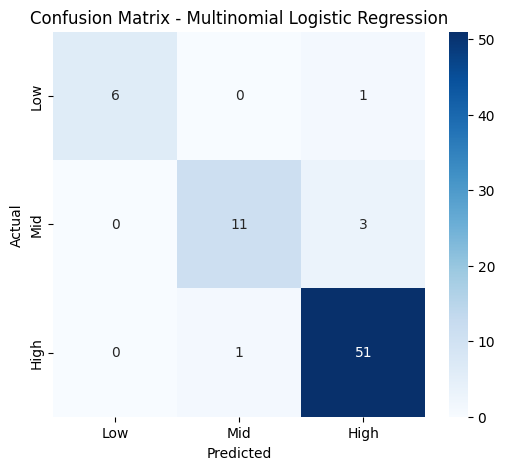

In [72]:
## TODO:
import seaborn as sns
from sklearn.metrics import f1_score,classification_report

# Predict class labels
y_pred = logreg_pipeline.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)

# Macro F1-score (averages F1 across classes equally)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Test Accuracy: {acc:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")


print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Low', 'Mid', 'High']))


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Mid', 'High'],
            yticklabels=['Low', 'Mid', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multinomial Logistic Regression')
plt.show()
